In [24]:
from sklearn.metrics import r2_score
%run helper_functions.py
%run prophet_helper.py #this runs the TS models for features
%run regression_ts_model.py #nested TS script 
%run btc_info_df.py #helps loan jup new BTC data
%autosave 120
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)

Autosaving every 120 seconds


# Notebook Overview

In this notebook, I will construct:
- A naive model of bitcoin price prediction

- A **nested** time series model.

#### What do I mean by a nested time series model?

I will illustrate with a simple example.

Let's say that I wish to predict the `mkt_price` on `2016-10-30`. I could fit a Linear Regression on all the features from `2016-10-26 - 29-10-2016`. However, in order to predict the price of `mkt_price` on `2016-10-30` I need to have values for the features on `2016-10-30`. This presents a problem as all my features are time series! That is, I cannot simply plug in a value for all the features because I don't know what their values would be on this future date!

One possible remedy for this is to simply use the values of all the features on `2016-10-29`. In fact, it is well know that the best predictor of a variable tomorrow is it's current state today. However, I wish to be more rigorous.

Instead of simply plugging in `t-1` values for the features at time `t`, I construct a time series model for _each_ feature in order to **predict** its value at time `t` based on the **entire** history of data that I have for the features!

These predicted values are then passed as inputs to our linear regression models!

Thus, if I have N features, I am creating N-Time Series models in order to do a single prediction with Linear Regression for the `mkt_price` variable.

### Naive Baseline Model

I will construct a naive baseline model that will most likely outperorm any other model I build below.

The model will work as follows:

When predicting the price on Day 91, I will take the average price change between Day 90 and Day 0. Let's call this average price change _alpha_.

I will then take the price of Day 90 and add _alpha_ to it. This will serve as the 'predicted' price for day 91.

In [14]:
df = unpickle_object("FINAL_DATAFRAME_PROJ_5.pkl")
df.head()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,avg_trans_per_block,mkt_price
date,,,,,,,,,,
2016-10-26,1273.9,11.455,0.143706,0.066297,225924.0,431781.0,1.752433e+06,69811.000000,1625.352518,672.221413
2016-10-27,1269.3,11.515,0.127429,0.064310,326388.0,457806.0,2.042404e+06,171358.250000,2014.740741,682.223962
2016-10-28,1265.9,11.280,0.128794,0.056393,250876.0,434269.0,1.916330e+06,131888.333333,1650.500000,687.688337
2016-10-29,1265.9,10.770,0.139114,0.063177,229689.0,416457.0,1.878507e+06,17765.750000,1541.536913,714.895450
2016-10-30,1265.9,10.805,0.131922,0.064369,209337.0,360327.0,2.130656e+06,20822.250000,1238.680473,698.003400


In [15]:
def linear_extrapolation(df, window):
    pred_lst = []
    true_lst = []

    cnt = 0

    all_rows = df.shape[0]

    while cnt < window:
        start = df.iloc[cnt:all_rows-window+cnt, :].index[0].date()
        end = df.iloc[cnt:all_rows-window+cnt, :].index[-1].date()
        predicting = df.iloc[all_rows-window+cnt, :].name.date()

        print("---- Running model from {} to {} and predicting on {} ----".format(start,end,predicting))

        training_df = df.iloc[cnt:all_rows-window+cnt, :]

        testing_df = df.iloc[all_rows-window+cnt, :]
        
        true_val = testing_df[-1]
        
        first_row_value = training_df.iloc[0, :]['mkt_price']
        first_row_date = training_df.iloc[0, :].name
        
        last_row_value = training_df.iloc[-1, :]['mkt_price']
        last_row_date = training_df.iloc[-1, :].name
        
        alpha = (last_row_value-first_row_value)/90
        
        prediction = last_row_value + alpha
        
        pred_lst.append(prediction)
        
        true_lst.append(true_val)
        
        
        cnt += 1
        
    return pred_lst, true_lst

In [16]:
pred_lst, true_lst = linear_extrapolation(df, 30)

---- Running model from 2016-10-26 to 2017-01-23 and predicting on 2017-01-24 ----
---- Running model from 2016-10-27 to 2017-01-24 and predicting on 2017-01-25 ----
---- Running model from 2016-10-28 to 2017-01-25 and predicting on 2017-01-26 ----
---- Running model from 2016-10-29 to 2017-01-26 and predicting on 2017-01-27 ----
---- Running model from 2016-10-30 to 2017-01-27 and predicting on 2017-01-28 ----
---- Running model from 2016-10-31 to 2017-01-28 and predicting on 2017-01-29 ----
---- Running model from 2016-11-01 to 2017-01-29 and predicting on 2017-01-30 ----
---- Running model from 2016-11-02 to 2017-01-30 and predicting on 2017-01-31 ----
---- Running model from 2016-11-03 to 2017-01-31 and predicting on 2017-02-01 ----
---- Running model from 2016-11-04 to 2017-02-01 and predicting on 2017-02-02 ----
---- Running model from 2016-11-05 to 2017-02-02 and predicting on 2017-02-03 ----
---- Running model from 2016-11-06 to 2017-02-03 and predicting on 2017-02-04 ----
----

In [17]:
r2_score(true_lst, pred_lst)

0.86689253204369099

### Naïve Model Caveats

We can see above that we can use this extremely basic model to obtain an $R^2$ of 0.86. In fact, this should be the baseline model score that we need to beat!

Let me mention some caveats to this result:

- I only have 4 months of Bitcoin data. It should be obvious to the reader that such a naive model is NOT the appropriate way to forecast bitcoin price in general. For if it were this simple, we would all be millionaires.


- Since I have 120 days worth of day, I am choosing to subset my data in 90 day periods, as such, I will produce 30 predictions. The variability of bitcoin prices around these 30 days will significantly impact the $R^2$ score. Again, more data is needed.


- While bitcoin data itself is not hard to come by, twitter data is! It is the twitter data that is limiting a deeper analysis. I hope that this notebook serves as a starting point for further investigation in the relationship between tweets and bitcoin price fluctuations.


- Lastly, I have made this notebook in Sept. 2017. The data for this project spans Oct 2016 - Feb 2017. Since that timeframe, bitcoin grew to unprecedented highs of \$4k/coin. Furthermore, media sound bites of CEOs such as James Dimon of JPMorgan have sent bitcoin prices tumbling by as much as $1k/coin. For me, this is what truly lies at the crux of the difficulty of cryptocurrency forecasting. I searched at great length for a **free**, searchable NEWS API, however, I could not find one. I think I great next step for this project would be to incorporate sentiment of news headlines concerning bitcoin!


- Furthermore, with the aforementioned timeframe, the overall bitcoin trend was upward. That is, there was not that much volatility in the price - as such, it is expected that the Naïve Model would outperform the nested time series model. The next step would again, be to collect more data and re-run all the models.

### Nested Time Series Model

In [18]:
df = unpickle_object("FINAL_DATAFRAME_PROJ_5.pkl")
df.head()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,avg_trans_per_block,mkt_price
date,,,,,,,,,,
2016-10-26,1273.9,11.455,0.143706,0.066297,225924.0,431781.0,1.752433e+06,69811.000000,1625.352518,672.221413
2016-10-27,1269.3,11.515,0.127429,0.064310,326388.0,457806.0,2.042404e+06,171358.250000,2014.740741,682.223962
2016-10-28,1265.9,11.280,0.128794,0.056393,250876.0,434269.0,1.916330e+06,131888.333333,1650.500000,687.688337
2016-10-29,1265.9,10.770,0.139114,0.063177,229689.0,416457.0,1.878507e+06,17765.750000,1541.536913,714.895450
2016-10-30,1265.9,10.805,0.131922,0.064369,209337.0,360327.0,2.130656e+06,20822.250000,1238.680473,698.003400


In [19]:
df.corr()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,avg_trans_per_block,mkt_price
gold_price,1.000000,0.757126,-0.144099,-0.253473,-0.145614,-0.179554,-0.078998,0.087767,-0.101640,-0.192922
eth_price,0.757126,1.000000,-0.164950,-0.116261,0.054744,0.015746,0.424836,0.272740,0.071475,0.354780
pos_sent,-0.144099,-0.164950,1.000000,-0.331122,-0.364671,-0.314049,-0.046629,-0.110460,-0.323005,0.095882
neg_sent,-0.253473,-0.116261,-0.331122,1.000000,0.232886,0.186956,0.159483,0.316399,0.217727,0.062722
tot_num_trans,-0.145614,0.054744,-0.364671,0.232886,1.000000,0.912685,0.300830,0.405603,0.743069,0.256059
unique_addr,-0.179554,0.015746,-0.314049,0.186956,0.912685,1.000000,0.303917,0.313126,0.692544,0.278896
hash_rate,-0.078998,0.424836,-0.046629,0.159483,0.300830,0.303917,1.000000,0.289567,-0.023170,0.784233
mempool_trans,0.087767,0.272740,-0.110460,0.316399,0.405603,0.313126,0.289567,1.000000,0.362882,0.249801
avg_trans_per_block,-0.101640,0.071475,-0.323005,0.217727,0.743069,0.692544,-0.023170,0.362882,1.000000,0.228785
mkt_price,-0.192922,0.354780,0.095882,0.062722,0.256059,0.278896,0.784233,0.249801,0.228785,1.000000


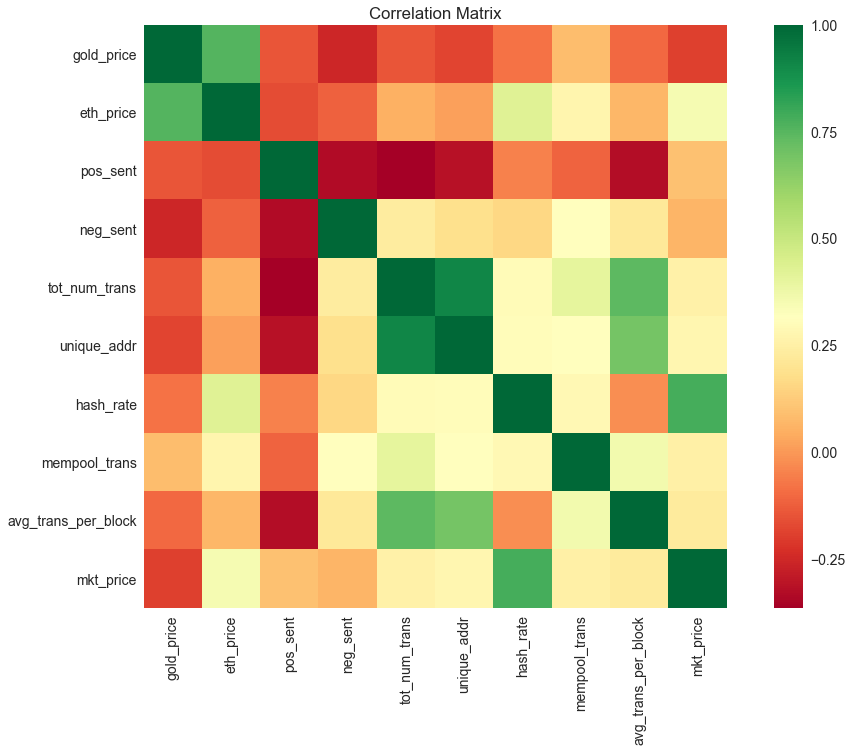

In [20]:
plot_corr_matrix(df)

In [21]:
beta_values, pred, true = master(df, 30)

---- Running model from 2016-10-26 to 2017-01-23 and predicting on 2017-01-24 ----
Creating Time series models: 
The real value for gold_price on 2017-01-24 is 1213.2999999998965
The predicted value for gold_price on 2017-01-24 is 1221.11026869873
The real value for eth_price on 2017-01-24 is 10.680000000000259
The predicted value for eth_price on 2017-01-24 is 10.965185902923128
The real value for pos_sent on 2017-01-24 is 0.12018382032272137
The predicted value for pos_sent on 2017-01-24 is 0.13216508320142728
The real value for neg_sent on 2017-01-24 is 0.06455189707806362
The predicted value for neg_sent on 2017-01-24 is 0.06816904538398737
The real value for tot_num_trans on 2017-01-24 is 278177.0
The predicted value for tot_num_trans on 2017-01-24 is 282370.2436552672
The real value for unique_addr on 2017-01-24 is 497858.0
The predicted value for unique_addr on 2017-01-24 is 496028.5135409737
The real value for hash_rate on 2017-01-24 is 2910612.1491232086
The predicted value fo

The predicted value for gold_price on 2017-01-26 is 1214.577889262119
The real value for eth_price on 2017-01-26 is 10.580000000001139
The predicted value for eth_price on 2017-01-26 is 11.256516397426093
The real value for pos_sent on 2017-01-26 is 0.13635754431474312
The predicted value for pos_sent on 2017-01-26 is 0.1258370614805339
The real value for neg_sent on 2017-01-26 is 0.06979420665801993
The predicted value for neg_sent on 2017-01-26 is 0.06932766812476852
The real value for tot_num_trans on 2017-01-26 is 317904.0
The predicted value for tot_num_trans on 2017-01-26 is 285819.4406849477
The real value for unique_addr on 2017-01-26 is 518118.0
The predicted value for unique_addr on 2017-01-26 is 475889.51102365635
The real value for hash_rate on 2017-01-26 is 3066886.6269284827
The predicted value for hash_rate on 2017-01-26 is 2962157.562481624
The real value for mempool_trans on 2017-01-26 is 194245.5
The predicted value for mempool_trans on 2017-01-26 is 79162.04703379996

The predicted value for eth_price on 2017-01-28 is 11.056536918371878
The real value for pos_sent on 2017-01-28 is 0.151849140974347
The predicted value for pos_sent on 2017-01-28 is 0.13568027908229693
The real value for neg_sent on 2017-01-28 is 0.060212285243586704
The predicted value for neg_sent on 2017-01-28 is 0.07043870103503579
The real value for tot_num_trans on 2017-01-28 is 246395.0
The predicted value for tot_num_trans on 2017-01-28 is 260730.73632839049
The real value for unique_addr on 2017-01-28 is 461291.0
The predicted value for unique_addr on 2017-01-28 is 453344.2814615224
The real value for hash_rate on 2017-01-28 is 2969215.0783001864
The predicted value for hash_rate on 2017-01-28 is 3019045.1569345775
The real value for mempool_trans on 2017-01-28 is 16016.5
The predicted value for mempool_trans on 2017-01-28 is 53653.96974985474
The real value for avg_trans_per_block on 2017-01-28 is 1621.0197368421052
The predicted value for avg_trans_per_block on 2017-01-28 i

The predicted value for pos_sent on 2017-01-30 is 0.13143704752745614
The real value for neg_sent on 2017-01-30 is 0.07339500542888144
The predicted value for neg_sent on 2017-01-30 is 0.0635436765881497
The real value for tot_num_trans on 2017-01-30 is 250829.0
The predicted value for tot_num_trans on 2017-01-30 is 263864.7633348682
The real value for unique_addr on 2017-01-30 is 449341.0
The predicted value for unique_addr on 2017-01-30 is 473593.5051955378
The real value for hash_rate on 2017-01-30 is 2852009.2199462317
The predicted value for hash_rate on 2017-01-30 is 3038363.9205564815
The real value for mempool_trans on 2017-01-30 is 30839.0
The predicted value for mempool_trans on 2017-01-30 is 21039.70359582609
The real value for avg_trans_per_block on 2017-01-30 is 1718.0068493150684
The predicted value for avg_trans_per_block on 2017-01-30 is 1677.3441009734142
The real value of mkt_price was [[ 921.179325]] on 2017-01-30
The predicted value of mkt_price was [[ 960.4465163]]

The predicted value for neg_sent on 2017-02-01 is 0.07407949605681498
The real value for tot_num_trans on 2017-02-01 is 350560.0
The predicted value for tot_num_trans on 2017-02-01 is 297561.519393831
The real value for unique_addr on 2017-02-01 is 599052.0
The predicted value for unique_addr on 2017-02-01 is 491752.5003970177
The real value for hash_rate on 2017-02-01 is 3750587.467326551
The predicted value for hash_rate on 2017-02-01 is 3085268.9895366626
The real value for mempool_trans on 2017-02-01 is 104770.0
The predicted value for mempool_trans on 2017-02-01 is 58497.52160568198
The real value for avg_trans_per_block on 2017-02-01 is 1825.833333333333
The predicted value for avg_trans_per_block on 2017-02-01 is 1844.9365915217177
The real value of mkt_price was [[ 979.703875]] on 2017-02-01
The predicted value of mkt_price was [[ 954.93609912]] on 2017-02-01

                            OLS Regression Results                            
Dep. Variable:                      y   

The predicted value for tot_num_trans on 2017-02-03 is 274621.5470219509
The real value for unique_addr on 2017-02-03 is 560374.0
The predicted value for unique_addr on 2017-02-03 is 464913.8249098099
The real value for hash_rate on 2017-02-03 is 2910612.1491232086
The predicted value for hash_rate on 2017-02-03 is 3172480.2817198285
The real value for mempool_trans on 2017-02-03 is 67658.83333333333
The predicted value for mempool_trans on 2017-02-03 is 57483.328148777335
The real value for avg_trans_per_block on 2017-02-03 is 2171.5637583892617
The predicted value for avg_trans_per_block on 2017-02-03 is 1724.3294573087444
The real value of mkt_price was [[ 1013.027]] on 2017-02-03
The predicted value of mkt_price was [[ 993.16408312]] on 2017-02-03

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.640


The predicted value for unique_addr on 2017-02-05 is 442071.9611441848
The real value for hash_rate on 2017-02-05 is 3336807.8208021554
The predicted value for hash_rate on 2017-02-05 is 3219645.6315634246
The real value for mempool_trans on 2017-02-05 is 83431.5
The predicted value for mempool_trans on 2017-02-05 is 34325.944461652296
The real value for avg_trans_per_block on 2017-02-05 is 1837.1132075471694
The predicted value for avg_trans_per_block on 2017-02-05 is 1568.8658356712233
The real value of mkt_price was [[ 1014.837725]] on 2017-02-05
The predicted value of mkt_price was [[ 984.56080747]] on 2017-02-05

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     19.89
Date:                Sun, 17 Sep 2017   Prob (F-statistic)

The predicted value for hash_rate on 2017-02-07 is 3113577.2653616993
The real value for mempool_trans on 2017-02-07 is 126099.0
The predicted value for mempool_trans on 2017-02-07 is 44713.74393071981
The real value for avg_trans_per_block on 2017-02-07 is 2154.092715231788
The predicted value for avg_trans_per_block on 2017-02-07 is 1902.8324530148684
The real value of mkt_price was [[ 1050.11]] on 2017-02-07
The predicted value of mkt_price was [[ 998.78996259]] on 2017-02-07

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     19.75
Date:                Sun, 17 Sep 2017   Prob (F-statistic):           5.64e-17
Time:                        16:20:10   Log-Likelihood:                -490.65
No. Observations:                  90   A

The predicted value for mempool_trans on 2017-02-09 is 72944.22521425379
The real value for avg_trans_per_block on 2017-02-09 is 2050.5562130177514
The predicted value for avg_trans_per_block on 2017-02-09 is 1737.422301989725
The real value of mkt_price was [[ 976.103]] on 2017-02-09
The predicted value of mkt_price was [[ 1011.19947387]] on 2017-02-09

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     19.88
Date:                Sun, 17 Sep 2017   Prob (F-statistic):           4.74e-17
Time:                        16:20:30   Log-Likelihood:                -492.86
No. Observations:                  90   AIC:                             1006.
Df Residuals:                      80   BIC:                             1031.
Df Model:  

The predicted value for avg_trans_per_block on 2017-02-11 is 1720.2243466513605
The real value of mkt_price was [[ 1008.8466625]] on 2017-02-11
The predicted value of mkt_price was [[ 996.74010998]] on 2017-02-11

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     19.72
Date:                Sun, 17 Sep 2017   Prob (F-statistic):           5.89e-17
Time:                        16:20:51   Log-Likelihood:                -492.90
No. Observations:                  90   AIC:                             1006.
Df Residuals:                      80   BIC:                             1031.
Df Model:                           9                                         
Covariance Type:            nonrobust                                      

The predicted value for gold_price on 2017-02-14 is 1240.1845587927392
The real value for eth_price on 2017-02-14 is 12.16000000000159
The predicted value for eth_price on 2017-02-14 is 11.973016690800781
The real value for pos_sent on 2017-02-14 is 0.13862701966128066
The predicted value for pos_sent on 2017-02-14 is 0.1284749280158903
The real value for neg_sent on 2017-02-14 is 0.0641516449289469
The predicted value for neg_sent on 2017-02-14 is 0.062465288713755986
The real value for tot_num_trans on 2017-02-14 is 315084.0
The predicted value for tot_num_trans on 2017-02-14 is 303649.3179385784
The real value for unique_addr on 2017-02-14 is 530239.0
The predicted value for unique_addr on 2017-02-14 is 515500.3358781535
The real value for hash_rate on 2017-02-14 is 3546669.9478966305
The predicted value for hash_rate on 2017-02-14 is 3333903.292610822
The real value for mempool_trans on 2017-02-14 is 28684.0
The predicted value for mempool_trans on 2017-02-14 is 51307.197991809386


The predicted value for eth_price on 2017-02-16 is 12.270495245566854
The real value for pos_sent on 2017-02-16 is 0.13962691259694007
The predicted value for pos_sent on 2017-02-16 is 0.13340775925050083
The real value for neg_sent on 2017-02-16 is 0.052306644309369155
The predicted value for neg_sent on 2017-02-16 is 0.06303227087393933
The real value for tot_num_trans on 2017-02-16 is 285329.0
The predicted value for tot_num_trans on 2017-02-16 is 292286.0793956967
The real value for unique_addr on 2017-02-16 is 489189.0
The predicted value for unique_addr on 2017-02-16 is 495696.30292128155
The real value for hash_rate on 2017-02-16 is 3189904.331836023
The predicted value for hash_rate on 2017-02-16 is 3376436.8448373787
The real value for mempool_trans on 2017-02-16 is 49404.75
The predicted value for mempool_trans on 2017-02-16 is 72275.70897395269
The real value for avg_trans_per_block on 2017-02-16 is 1877.1644736842104
The predicted value for avg_trans_per_block on 2017-02-16

The predicted value for pos_sent on 2017-02-18 is 0.14084628180437464
The real value for neg_sent on 2017-02-18 is 0.057815085771947515
The predicted value for neg_sent on 2017-02-18 is 0.0657696700582197
The real value for tot_num_trans on 2017-02-18 is 288149.0
The predicted value for tot_num_trans on 2017-02-18 is 268496.6754313435
The real value for unique_addr on 2017-02-18 is 510385.0
The predicted value for unique_addr on 2017-02-18 is 475727.42162932764
The real value for hash_rate on 2017-02-18 is 3330515.7440737467
The predicted value for hash_rate on 2017-02-18 is 3196782.323225993
The real value for mempool_trans on 2017-02-18 is 109288.5
The predicted value for mempool_trans on 2017-02-18 is 87375.69918965909
The real value for avg_trans_per_block on 2017-02-18 is 1895.717105263158
The predicted value for avg_trans_per_block on 2017-02-18 is 1813.3483623358163
The real value of mkt_price was [[ 1056.6371375]] on 2017-02-18
The predicted value of mkt_price was [[ 1026.89119

The predicted value for neg_sent on 2017-02-20 is 0.06387564126992515
The real value for tot_num_trans on 2017-02-20 is 282728.0
The predicted value for tot_num_trans on 2017-02-20 is 267847.1313055606
The real value for unique_addr on 2017-02-20 is 503952.0
The predicted value for unique_addr on 2017-02-20 is 493904.96453395224
The real value for hash_rate on 2017-02-20 is 3242870.5929139117
The predicted value for hash_rate on 2017-02-20 is 3191024.7961319247
The real value for mempool_trans on 2017-02-20 is 45046.0
The predicted value for mempool_trans on 2017-02-20 is 33473.96008814016
The real value for avg_trans_per_block on 2017-02-20 is 1910.3243243243246
The predicted value for avg_trans_per_block on 2017-02-20 is 1894.654141264163
The real value of mkt_price was [[ 1084.7550125]] on 2017-02-20
The predicted value of mkt_price was [[ 1034.34281822]] on 2017-02-20

                            OLS Regression Results                            
Dep. Variable:                     

The predicted value for tot_num_trans on 2017-02-22 is 325586.05845974287
The real value for unique_addr on 2017-02-22 is 489247.0
The predicted value for unique_addr on 2017-02-22 is 517499.1792197267
The real value for hash_rate on 2017-02-22 is 3045669.0028042817
The predicted value for hash_rate on 2017-02-22 is 3442911.116577757
The real value for mempool_trans on 2017-02-22 is 229240.5
The predicted value for mempool_trans on 2017-02-22 is 139660.40170705027
The real value for avg_trans_per_block on 2017-02-22 is 2043.3381294964029
The predicted value for avg_trans_per_block on 2017-02-22 is 2085.242314553381
The real value of mkt_price was [[ 1123.2231875]] on 2017-02-22
The predicted value of mkt_price was [[ 1078.0909001]] on 2017-02-22

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.682
Method

In [22]:
r2_score(true, pred)#blows our Prophet TS only model away!

0.75234861747398374

#### Nested TS VS. FB Prophet TS

We see from the above that our model has an $R^2$ of 0.75! This greatly outperforms our baseline model of just using FaceBook Prophet to forecast the price of bitcoin! The RMSE is 1.40

This is quite impressive given that we only have 3 months of training data and are testing on one month!

The output above also shows regression output from statsmodels!

The following features were significant in all 30 models:

- Gold Price

- Ethereum Price

- Positive Sentiment (Yay!)

- Average Transactions Per Block

It is important, yet again, to note that this data does NOT take into account the wild fluctuations in price that bitcoin later experienced. We would need more data to affirm the significance of the above variables.

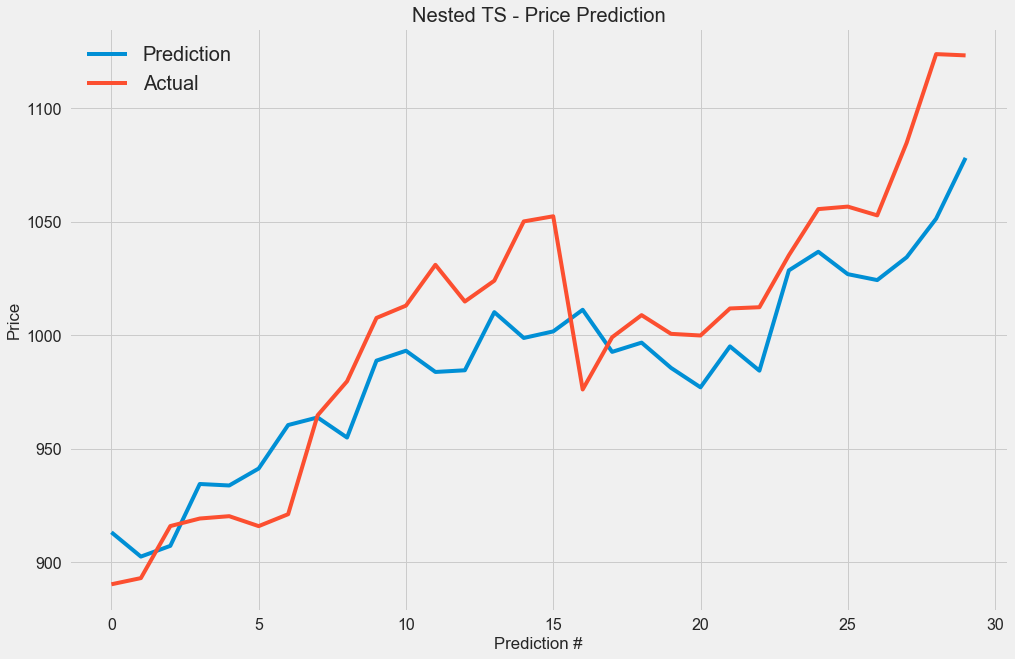

In [25]:
plt.plot(pred)
plt.plot(true)
plt.legend(["Prediction", 'Actual'], loc='upper left')
plt.xlabel("Prediction #")
plt.ylabel("Price")
plt.title("Nested TS - Price Prediction");

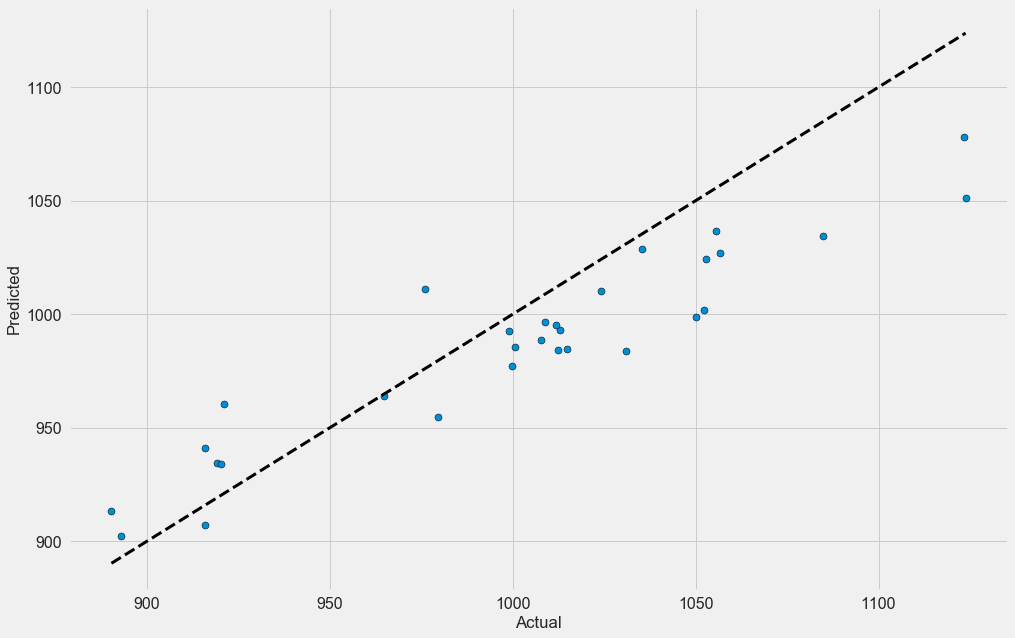

In [26]:
fig, ax = plt.subplots()
ax.scatter(true, pred, edgecolors=(0, 0, 0))
ax.plot([min(true), max(true)], [min(true), max(true)], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

In [27]:
plotting_dict_1 = {"eth_price": [], "pos_sent": [], "neg_sent": [], "unique_addr": [], "gold_price": [], "tot_num_trans": [], "mempool_trans":[], "hash_rate": [], "avg_trans_per_block":[]}

for index, sub_list in enumerate(beta_values):
    for tup in sub_list:
        plotting_dict_1[tup[0]].append(tup[1])

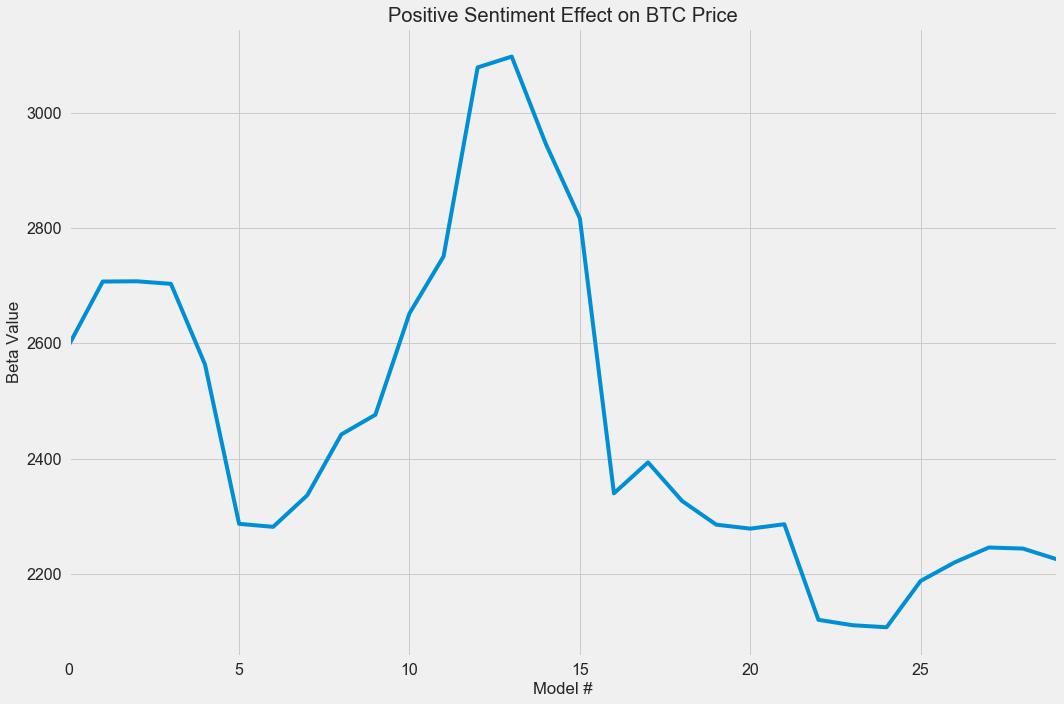

In [34]:
plot_key(plotting_dict_1, "pos_sent")# here we say the effect of positive sentiment through time!
plt.title("Positive Sentiment Effect on BTC Price")
plt.ylabel("Beta Value")
plt.xlabel("Model #")
plt.tight_layout()

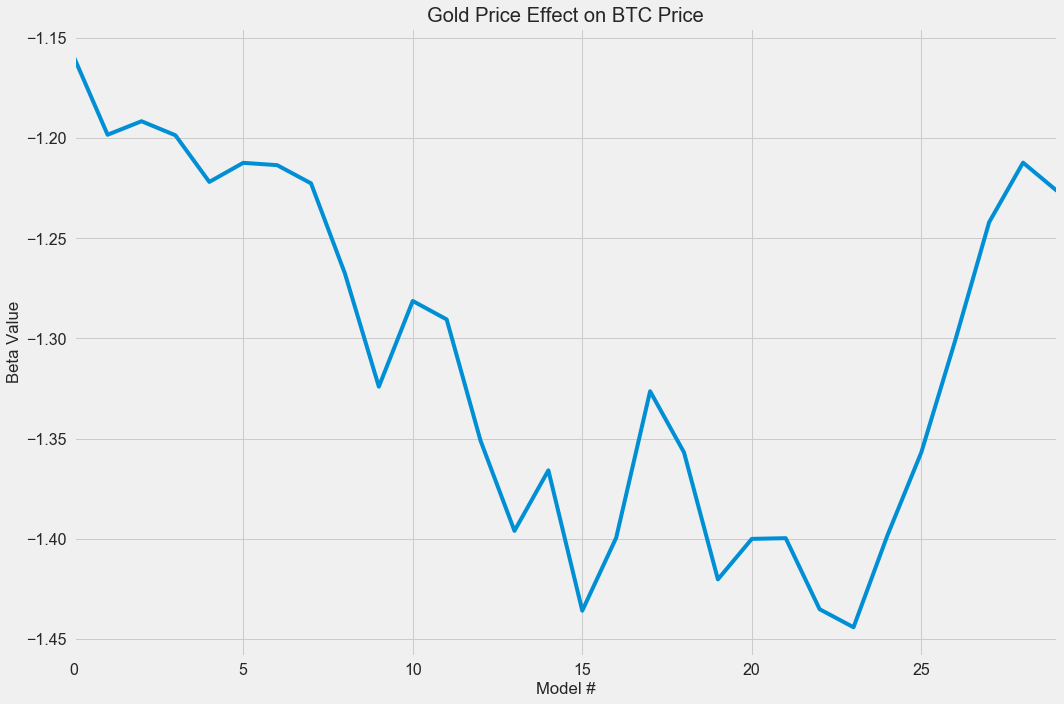

In [35]:
plot_key(plotting_dict_1, "gold_price")
plt.title("Gold Price Effect on BTC Price")
plt.ylabel("Beta Value")
plt.xlabel("Model #")
plt.tight_layout()

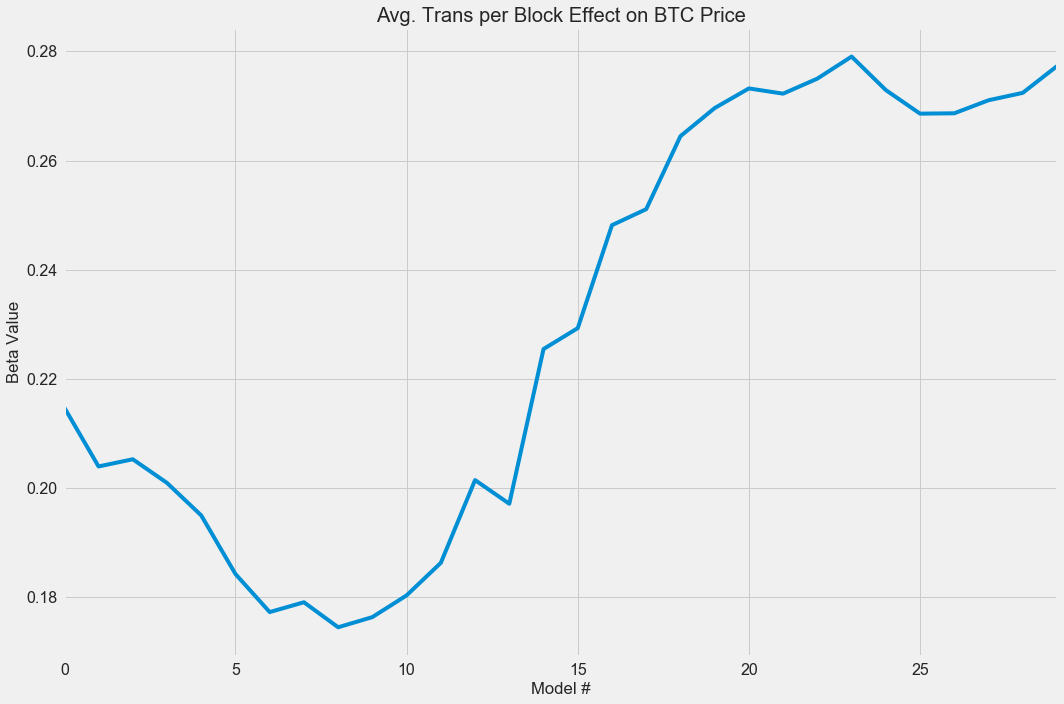

In [36]:
plot_key(plotting_dict_1, "avg_trans_per_block")
plt.title("Avg. Trans per Block Effect on BTC Price")
plt.ylabel("Beta Value")
plt.xlabel("Model #")
plt.tight_layout()

## Percent change model!

I will now run the same nested TS model as above, however, I will now make my 'target' variable the percent change in bitcoin price. In order to make this a log-og model, I will use the percentage change of all features as inputs into the TS model and thus the linear regression!

Since percent change will 'shift' our dataframe by one row, I omit the first row (which is all NaN's).

Thus, if we were to predict a percent change of $0.008010$ on `28-10-2017`, then this would mean that the **predicted price** would be the price on `27-10-2017` $*predicted\_percent\_change$.

In [4]:
df_pct = df.copy(deep=True)
df_pct = df_pct.pct_change()
df_pct.rename(columns={"mkt_price": "percent_change"}, inplace=True)
df_pct = df_pct.iloc[1:, :] #first row is all NaN's
df_pct.head()

,gold_price,eth_price,pos_sent,neg_sent,tot_num_trans,unique_addr,hash_rate,mempool_trans,avg_trans_per_block,percent_change
date,,,,,,,,,,
2016-10-27,-3.610958e-03,0.005238,-0.113268,-0.029983,0.444681,0.060274,0.165468,1.454602,0.239572,0.014880
2016-10-28,-2.678642e-03,-0.020408,0.010710,-0.123097,-0.231357,-0.051413,-0.061728,-0.230336,-0.180788,0.008010
2016-10-29,-4.996004e-15,-0.045213,0.080134,0.120302,-0.084452,-0.041016,-0.019737,-0.865297,-0.066018,0.039563
2016-10-30,-2.353673e-14,0.003250,-0.051700,0.018852,-0.088607,-0.134780,0.134228,0.172045,-0.196464,-0.023629
2016-10-31,6.556600e-03,0.028690,-0.004203,-0.260696,0.154970,0.273510,-0.130178,-0.317341,0.327823,0.005728


In [5]:
beta_values_p, pred_p, true_p = master(df_pct, 30)

---- Running model from 2016-10-27 to 2017-01-23 and predicting on 2017-01-24 ----
Creating Time series models: 
The real value for gold_price on 2017-01-24 is -0.00037075180235102145
The predicted value for gold_price on 2017-01-24 is 0.005760312059128465
The real value for eth_price on 2017-01-24 is -0.007895959126733021
The predicted value for eth_price on 2017-01-24 is 0.02477744372194353
The real value for pos_sent on 2017-01-24 is -0.10952281294819832
The predicted value for pos_sent on 2017-01-24 is -0.047601683404250084
The real value for neg_sent on 2017-01-24 is 0.14629332553048702
The predicted value for neg_sent on 2017-01-24 is -0.001670140565898595
The real value for tot_num_trans on 2017-01-24 is 0.17526997110168496
The predicted value for tot_num_trans on 2017-01-24 is 0.19600695623048575
The real value for unique_addr on 2017-01-24 is 0.16673072236074926
The predicted value for unique_addr on 2017-01-24 is 0.017314970604224898
The real value for hash_rate on 2017-01-24

The predicted value for gold_price on 2017-01-26 is -0.0026370245442384225
The real value for eth_price on 2017-01-26 is -0.0014157621519175212
The predicted value for eth_price on 2017-01-26 is 0.0036850316459171983
The real value for pos_sent on 2017-01-26 is 0.059524584703593675
The predicted value for pos_sent on 2017-01-26 is 0.027214068087432153
The real value for neg_sent on 2017-01-26 is -0.08448885129794548
The predicted value for neg_sent on 2017-01-26 is 0.08009034706630527
The real value for tot_num_trans on 2017-01-26 is 0.03903438673556425
The predicted value for tot_num_trans on 2017-01-26 is -0.08134280907822058
The real value for unique_addr on 2017-01-26 is 0.0067620346729158065
The predicted value for unique_addr on 2017-01-26 is -0.06542449142480526
The real value for hash_rate on 2017-01-26 is 0.046666666666666634
The predicted value for hash_rate on 2017-01-26 is 0.04026325440246546
The real value for mempool_trans on 2017-01-26 is -0.10625772121496557
The predict

The predicted value for pos_sent on 2017-01-28 is 0.06234448018195863
The real value for neg_sent on 2017-01-28 is -0.21028049733533094
The predicted value for neg_sent on 2017-01-28 is -0.037663832003662905
The real value for tot_num_trans on 2017-01-28 is -0.06431804717998568
The predicted value for tot_num_trans on 2017-01-28 is -0.04906498243903882
The real value for unique_addr on 2017-01-28 is -0.003583540339129443
The predicted value for unique_addr on 2017-01-28 is 0.024747932809002268
The real value for hash_rate on 2017-01-28 is -0.10588235294117632
The predicted value for hash_rate on 2017-01-28 is 0.010113988708799638
The real value for mempool_trans on 2017-01-28 is -0.5156861855732451
The predicted value for mempool_trans on 2017-01-28 is 0.41519622253902577
The real value for avg_trans_per_block on 2017-01-28 is 0.04648639460133164
The predicted value for avg_trans_per_block on 2017-01-28 is -0.04142141482163712
The real value of percent_change was [[ 0.00112316]] on 201

The predicted value for tot_num_trans on 2017-01-30 is 0.18383180827984177
The real value for unique_addr on 2017-01-30 is 0.0241927212138755
The predicted value for unique_addr on 2017-01-30 is 0.1615705131354522
The real value for hash_rate on 2017-01-30 is -0.12574850299401197
The predicted value for hash_rate on 2017-01-30 is -0.026993423611225337
The real value for mempool_trans on 2017-01-30 is -0.0964651421707221
The predicted value for mempool_trans on 2017-01-30 is -0.14752085616271354
The real value for avg_trans_per_block on 2017-01-30 is 0.18739687135798744
The predicted value for avg_trans_per_block on 2017-01-30 is 0.243363900584849
The real value of percent_change was [[ 0.00572785]] on 2017-01-30
The predicted value of percent_change was [[ 0.01368477]] on 2017-01-30

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-

The predicted value for hash_rate on 2017-02-01 is -0.08117112769702206
The real value for mempool_trans on 2017-02-01 is 0.8324923259901877
The predicted value for mempool_trans on 2017-02-01 is 1.0391172982596015
The real value for avg_trans_per_block on 2017-02-01 is -0.13955001305456194
The predicted value for avg_trans_per_block on 2017-02-01 is 0.05980271188800578
The real value of percent_change was [[ 0.0155465]] on 2017-02-01
The predicted value of percent_change was [[ 0.01532338]] on 2017-02-01

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.817
Date:                Sun, 17 Sep 2017   Prob (F-statistic):             0.0781
Time:                        15:27:32   Log-Likelihood:                 190.35
No. Observatio

The predicted value for avg_trans_per_block on 2017-02-03 is -0.05873335613187458
The real value of percent_change was [[ 0.00537238]] on 2017-02-03
The predicted value of percent_change was [[ 0.00321369]] on 2017-02-03

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1.652
Date:                Sun, 17 Sep 2017   Prob (F-statistic):              0.115
Time:                        15:27:56   Log-Likelihood:                 189.53
No. Observations:                  89   AIC:                            -359.1
Df Residuals:                      79   BIC:                            -334.2
Df Model:                           9                                         
Covariance Type:            nonrobust                              

The predicted value for gold_price on 2017-02-06 is 0.009555411255081782
The real value for eth_price on 2017-02-06 is -0.0021939447124099676
The predicted value for eth_price on 2017-02-06 is 0.0045166054767428005
The real value for pos_sent on 2017-02-06 is -0.08624827856658379
The predicted value for pos_sent on 2017-02-06 is -0.002611160042591168
The real value for neg_sent on 2017-02-06 is -0.10744417790833793
The predicted value for neg_sent on 2017-02-06 is 0.09429391139753357
The real value for tot_num_trans on 2017-02-06 is -0.21250868706372106
The predicted value for tot_num_trans on 2017-02-06 is 0.13325330970284055
The real value for unique_addr on 2017-02-06 is -0.1369217111490426
The predicted value for unique_addr on 2017-02-06 is 0.1267611594596011
The real value for hash_rate on 2017-02-06 is -0.21383647798742123
The predicted value for hash_rate on 2017-02-06 is -0.06175458581947332
The real value for mempool_trans on 2017-02-06 is -0.5162139000257697
The predicted va

The predicted value for pos_sent on 2017-02-08 is 0.02786167160831258
The real value for neg_sent on 2017-02-08 is 0.09729079291134202
The predicted value for neg_sent on 2017-02-08 is -0.033058016672654775
The real value for tot_num_trans on 2017-02-08 is -0.052117023500620974
The predicted value for tot_num_trans on 2017-02-08 is -0.011213472836674784
The real value for unique_addr on 2017-02-08 is -0.07337770681210642
The predicted value for unique_addr on 2017-02-08 is -0.02319779156631299
The real value for hash_rate on 2017-02-08 is -0.03311258278145712
The predicted value for hash_rate on 2017-02-08 is 0.05407903260006898
The real value for mempool_trans on 2017-02-08 is 0.9855193141896446
The predicted value for mempool_trans on 2017-02-08 is 1.1626066164868865
The real value for avg_trans_per_block on 2017-02-08 is -0.019655277730094567
The predicted value for avg_trans_per_block on 2017-02-08 is -0.049732218149905666
The real value of percent_change was [[ 0.00215845]] on 201

The predicted value for tot_num_trans on 2017-02-10 is 0.005511837885388303
The real value for unique_addr on 2017-02-10 is -0.11751509112062986
The predicted value for unique_addr on 2017-02-10 is -0.0267686593328271
The real value for hash_rate on 2017-02-10 is -0.12426035502958566
The predicted value for hash_rate on 2017-02-10 is -0.0416126967983437
The real value for mempool_trans on 2017-02-10 is -0.4318269290093987
The predicted value for mempool_trans on 2017-02-10 is 0.22885964254121927
The real value for avg_trans_per_block on 2017-02-10 is 0.0032083597979992717
The predicted value for avg_trans_per_block on 2017-02-10 is 0.03718360154919892
The real value of percent_change was [[ 0.0235636]] on 2017-02-10
The predicted value of percent_change was [[ 0.00459717]] on 2017-02-10

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj

The predicted value for hash_rate on 2017-02-12 is 0.06478068404705742
The real value for mempool_trans on 2017-02-12 is -0.1881302951867725
The predicted value for mempool_trans on 2017-02-12 is 0.10452588271728602
The real value for avg_trans_per_block on 2017-02-12 is -0.1061437156342796
The predicted value for avg_trans_per_block on 2017-02-12 is -0.06479439403746852
The real value of percent_change was [[-0.00816976]] on 2017-02-12
The predicted value of percent_change was [[ 0.00387023]] on 2017-02-12

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.276
Date:                Sun, 17 Sep 2017   Prob (F-statistic):             0.0252
Time:                        15:29:37   Log-Likelihood:                 189.06
No. Observat

The predicted value for avg_trans_per_block on 2017-02-14 is 0.07140822065847156
The real value of percent_change was [[ 0.01190433]] on 2017-02-14
The predicted value of percent_change was [[ 0.01577612]] on 2017-02-14

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     2.239
Date:                Sun, 17 Sep 2017   Prob (F-statistic):             0.0277
Time:                        15:30:03   Log-Likelihood:                 189.33
No. Observations:                  89   AIC:                            -358.7
Df Residuals:                      79   BIC:                            -333.8
Df Model:                           9                                         
Covariance Type:            nonrobust                               

The predicted value for gold_price on 2017-02-17 is 0.002905478692173356
The real value for eth_price on 2017-02-17 is -0.009295120062030149
The predicted value for eth_price on 2017-02-17 is -0.001736334419482564
The real value for pos_sent on 2017-02-17 is 0.009194456351748759
The predicted value for pos_sent on 2017-02-17 is -0.0030516675932439324
The real value for neg_sent on 2017-02-17 is 0.034050263227086264
The predicted value for neg_sent on 2017-02-17 is 0.006684575465428715
The real value for tot_num_trans on 2017-02-17 is 0.12069575822997303
The predicted value for tot_num_trans on 2017-02-17 is -0.032935465469521676
The real value for unique_addr on 2017-02-17 is 0.12445700945851201
The predicted value for unique_addr on 2017-02-17 is -0.030488945562394273
The real value for hash_rate on 2017-02-17 is -0.006578947368421018
The predicted value for hash_rate on 2017-02-17 is -0.038594173673690085
The real value for mempool_trans on 2017-02-17 is 0.6862346231890659
The predic

The predicted value for pos_sent on 2017-02-19 is -0.046082344896733816
The real value for neg_sent on 2017-02-19 is -0.007564578038472658
The predicted value for neg_sent on 2017-02-19 is 0.011981741151610397
The real value for tot_num_trans on 2017-02-19 is -0.12642070595421118
The predicted value for tot_num_trans on 2017-02-19 is -0.050686158094634864
The real value for unique_addr on 2017-02-19 is -0.10068281787278233
The predicted value for unique_addr on 2017-02-19 is -0.050164309207817476
The real value for hash_rate on 2017-02-19 is -0.1184210526315791
The predicted value for hash_rate on 2017-02-19 is 0.07365234298756476
The real value for mempool_trans on 2017-02-19 is -0.6477900236529919
The predicted value for mempool_trans on 2017-02-19 is 0.1494717218969216
The real value for avg_trans_per_block on 2017-02-19 is -0.009074233619702166
The predicted value for avg_trans_per_block on 2017-02-19 is -0.094633589778181
The real value of percent_change was [[-0.00365107]] on 201

The predicted value for tot_num_trans on 2017-02-21 is 0.16852971548188977
The real value for unique_addr on 2017-02-21 is -0.03220941676985112
The predicted value for unique_addr on 2017-02-21 is 0.05379544010743445
The real value for hash_rate on 2017-02-21 is -0.06756756756756754
The predicted value for hash_rate on 2017-02-21 is 0.07426655179523217
The real value for mempool_trans on 2017-02-21 is 1.083248235137415
The predicted value for mempool_trans on 2017-02-21 is 1.1853443434545965
The real value for avg_trans_per_block on 2017-02-21 is 0.05866385021461684
The predicted value for avg_trans_per_block on 2017-02-21 is 0.07983681754264715
The real value of percent_change was [[ 0.03598362]] on 2017-02-21
The predicted value of percent_change was [[ 0.01568364]] on 2017-02-21

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-s

In [21]:
r2_score(true_p, pred_p) # this is expected due to the range of values on the y-axis!

-0.034659636867694132

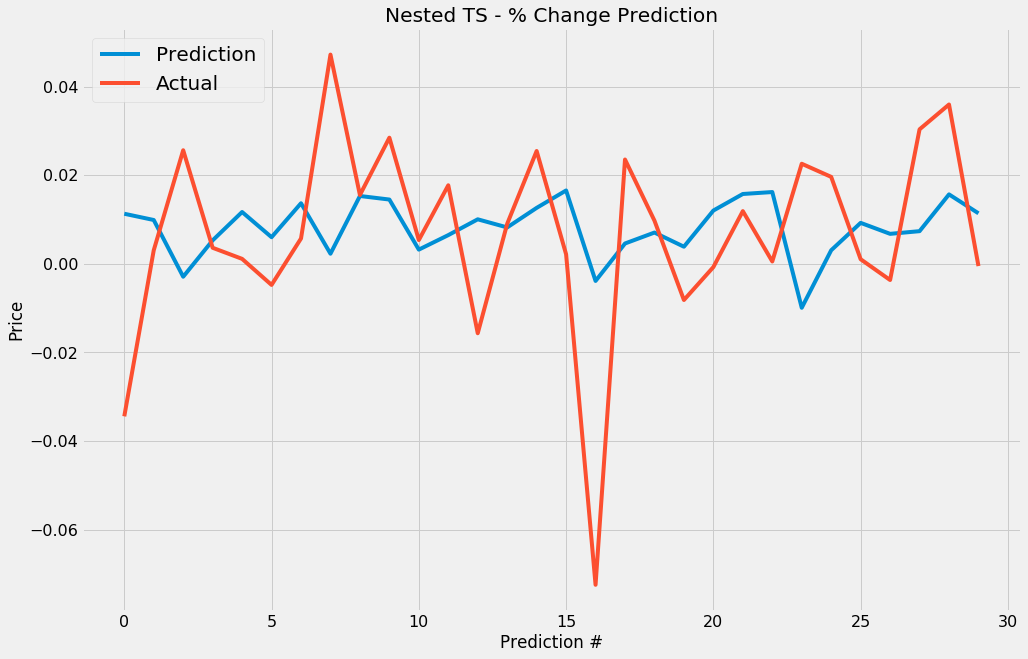

In [22]:
#very good!
plt.plot(pred_p)
plt.plot(true_p)
plt.legend(["Prediction", 'Actual'], loc='upper left')
plt.xlabel("Prediction #")
plt.ylabel("Price")
plt.title("Nested TS - % Change Prediction");

From the above, it seems that our model is not tuned well enough to anticipate the large dip shown above. This is due to a lack of training data. However, while our model might not be the best in predicting **percent change** how does it fair when we turn the percent change into **prices**.

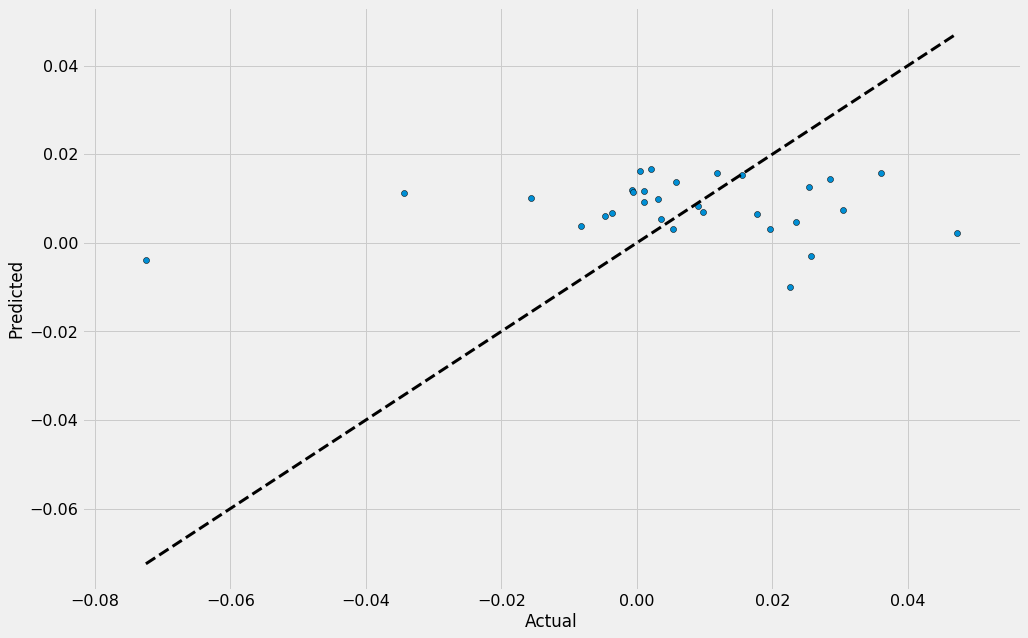

In [23]:
fig, ax = plt.subplots()
ax.scatter(true_p, pred_p, edgecolors=(0, 0, 0))
ax.plot([min(true), max(true)], [min(true), max(true)], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted');

In [28]:
df.set_index('date', inplace=True)
prices_to_be_multiplied = df.loc[pd.date_range(start="2017-01-23", end="2017-02-21"), "mkt_price"]
forecast_price_lst = []
for index, price in enumerate(prices_to_be_multiplied):
    predicted_percent_change = 1+float(pred_p[index])
    forecasted_price = (predicted_percent_change)*price
    forecast_price_lst.append(forecasted_price)
ground_truth_prices = df.loc[pd.date_range(start="2017-01-24", end="2017-02-22"), "mkt_price"]
ground_truth_prices = list(ground_truth_prices)
r2_score(ground_truth_prices, forecast_price_lst)

0.87042670228813868

We have an $R^2$ of 0.87!

This surpasses the baseline model and the nested TS model!

The caveats of the baseline model also apply here, however, it seems that the addition of additional variables have helped us **slightly** improve with regards to the $R^2$

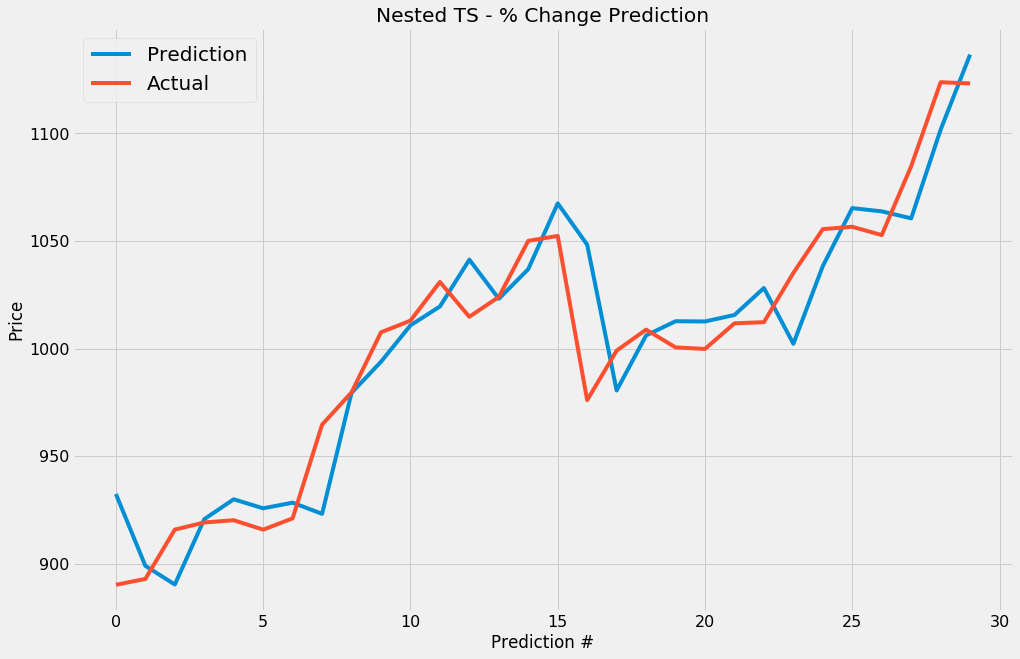

In [29]:
plt.plot(forecast_price_lst)
plt.plot(ground_truth_prices)
plt.legend(["Prediction", 'Actual'], loc='upper left')
plt.xlabel("Prediction #")
plt.ylabel("Price")
plt.title("Nested TS - % Change Prediction");